# "P_Delta_Analysis"
### A Tool for *Modeling* & *Analysis* of *2D Continuous Beams* with *Direct Stiffness Method*
![image-3.png](attachment:image-3.png)
#### 

### Post Analysis
#### Converting +ve directions
Direct Stiffness Method has a +ve direction convension for axial-load, shear and bending-moment which is different from Standard Static +ve direction convensions; and will be corrected.
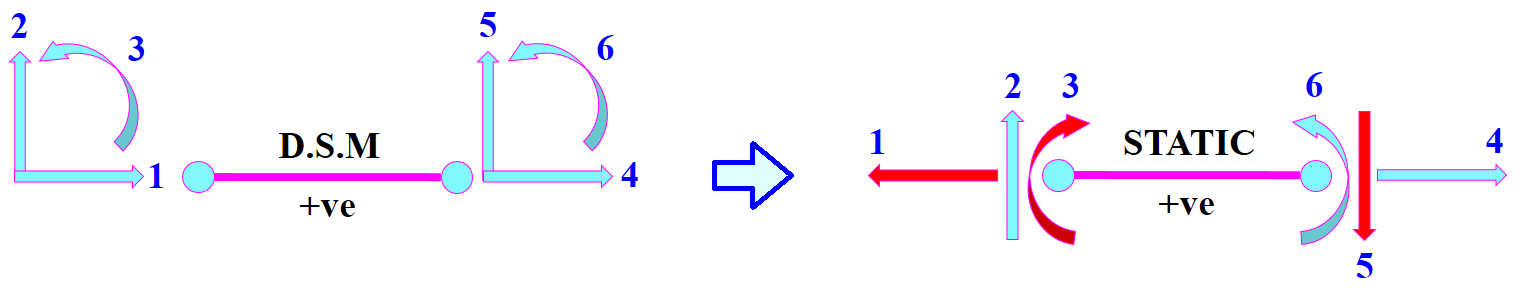

### Visualizing Support-Reactions
 - Rx: horizontal reaction (KN), +ve: left to right
 - Ry: vertical reaction (KN), +ve: upward
 - Rz: resistant-moment (KNm), +ve: counter-clockwise 
 - left outer support is Support_1
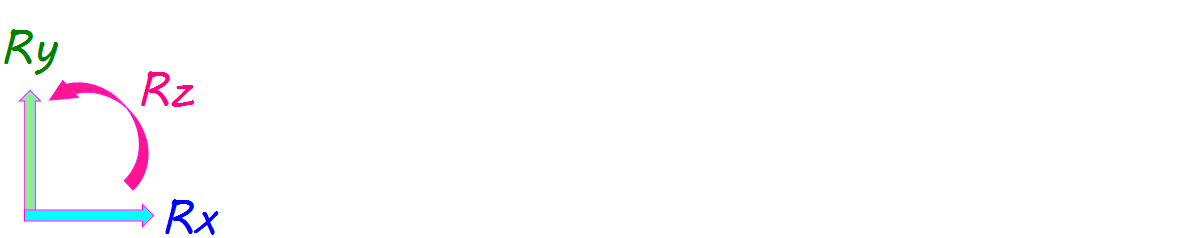

##### 

##### 
### Importing Libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sympy    import *
from My_Funcs import *

##### 
### (input) Sections & Dist-Loads & Point-Loads

In [2]:
# rectangular Distributed Load on Beams  (KN/mm)  ---  towards Ground is +ve 
w1 = 292.5/6000;     w2 = 135/4000; 

# Point-Loads on free supports  (KN)  ---  towards Ground is +ve  ---  only on "free" supports. other supports = 0
P1 = 25;         P2 = 55

# sections
# (input)        (auto)      
b,h = 500,900;   s1 = [ b*h, b*h**3/12 ]
b,h = 500,950;   s2 = [ b*h, b*h**3/12 ]
b,h = 600,950;   s3 = [ b*h, b*h**3/12 ]

##### 
### Structure Data (input)

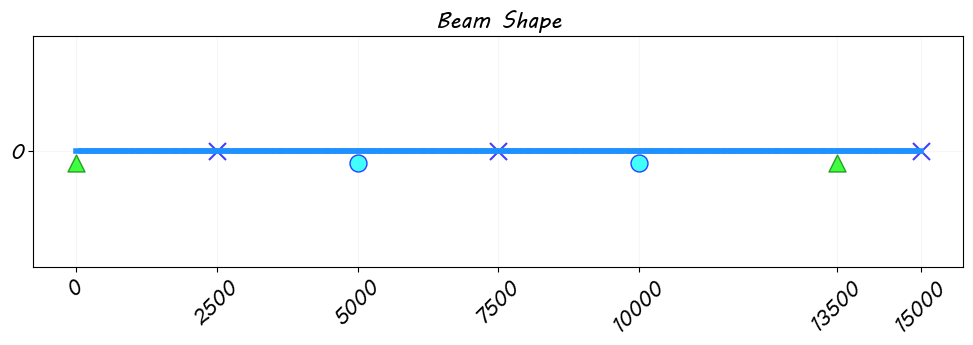

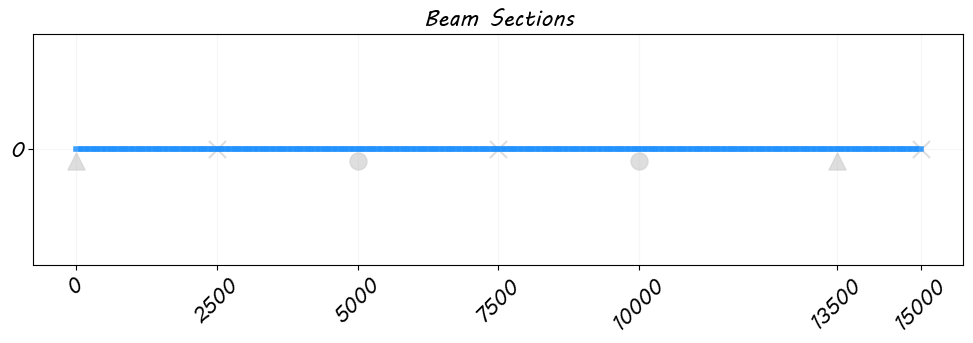

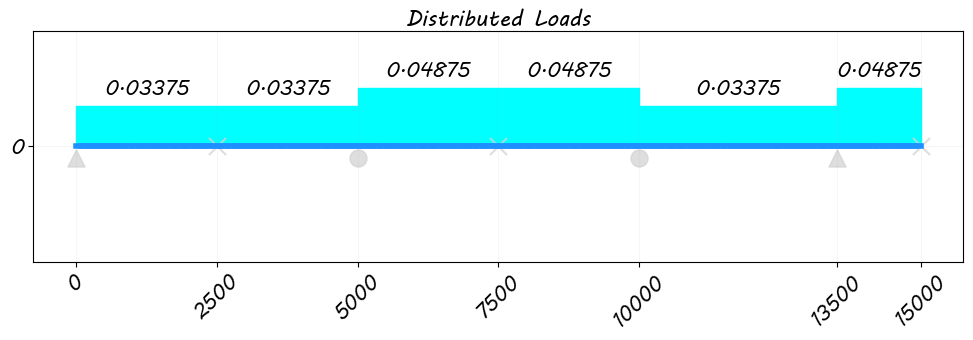

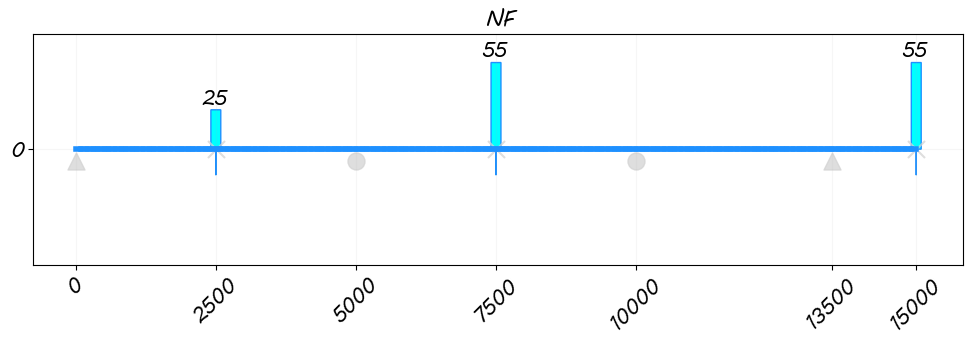

In [3]:
# (input)
L_tinyBeam  = 100      #  length of tiny beams (mm) --- the smaller the better   

wBay        = [       2500   ,   2500  ,  2500  ,  2500   ,   3500   ,  1500       ]  #  width of bays ( any amount )
W_Beams     = [        w2    ,    w2   ,   w1   ,   w1    ,    w2    ,   w1        ] 
Sections    = [        s1    ,    s1   ,   s1   ,   s1    ,    s1    ,   s1        ]
Supports    = ['pinned' , 'free' , 'roller' , 'free' , 'roller' , 'pinned' , 'free']  # 'fixed' 'pinned' 'roller' 'free'   Note: 'pinned' == 'roller' (Sum(Fx)==0)
Point_Loads = [   0     ,   P1   ,    0     ,   P2   ,    0     ,    0     ,   P2  ]  #  Only on 'free' supports

# (auto)
# material  ---  Modulus of Elasticity  ---  Concrete = 30  ---  Steel = 200  ---  (KN/mm2)
Ec = 30;   E_Beams = [ Ec ] * len(wBay)

#  multi-sectioning
nBeams_Main, wBay_Main, Supports, Supports_Idx, wBay, nPieces, nBay = MS( wBay, Supports, L_tinyBeam )
# Points & Connectivity Matrices
Points, CnB  =  PC( wBay )

[NOP, NOD, RD, FD, NFD, NB, IndxB] = Static_Coeff( Points, CnB, wBay, Supports )   # Finding Static Coefficients      
Beams        =  Multi_Beams(  E_Beams, Sections, W_Beams, nBeams_Main, nPieces )   # applying  E, A, I, W  to all pieces
Beams['C']   =  Beam_Color(   Beams                                            )   # coloring sections
NF           =  Nodal_Forces( Points,  Point_Loads,  NOD, nBeams_Main, nPieces )   # Nodal Forces


Beam_Shape(           Points, CnB, wBay_Main, wBay, Supports                   )   # checking beams shape
Plot_Sections(        Points, CnB, wBay_Main, wBay, Supports, Beams            )   # checking beams sections
Beam_Dist_Load_Shape( Points, CnB, wBay_Main, wBay, Supports, Beams, W_Beams   )   # checking beams dist. loads
NF_Shape(             Points, CnB, wBay_Main, wBay, Supports, NF               )   # checking beams NFs


##### 
### Analysis

In [4]:
# Ke Qf 
KE,QF, LB,TB,keB,KeB,qfB  =  KeQf( Points,  NOD, CnB, NB, IndxB, Beams )

# performing analysis
print('Analysis initiated ...')
qB, R, U = Analyze_Beam( NF,  NOD,  FD, KE,  QF, NB, IndxB, TB, keB, KeB, Beams, qfB )
print('Analysis finished.')


Analysis initiated ...
Analysis finished.


#####   
### Post Analysis

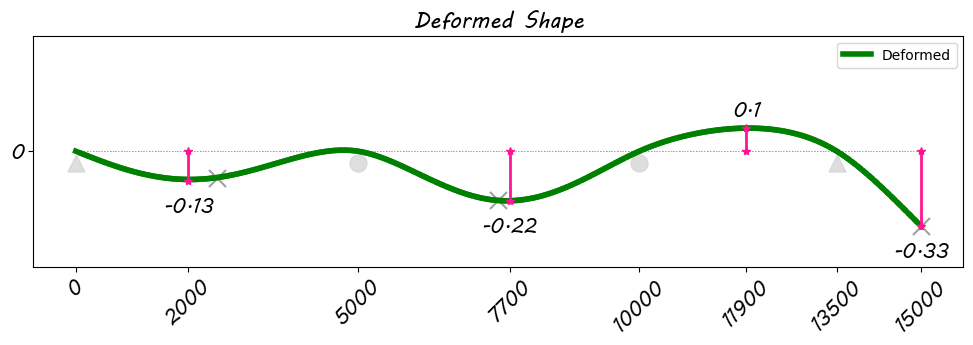

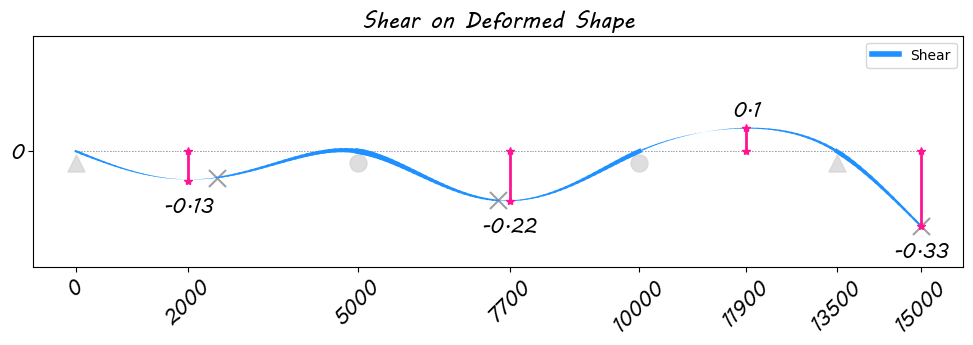

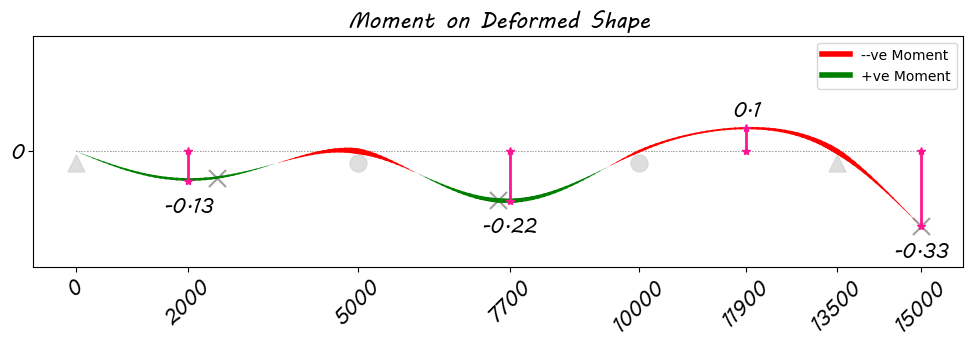

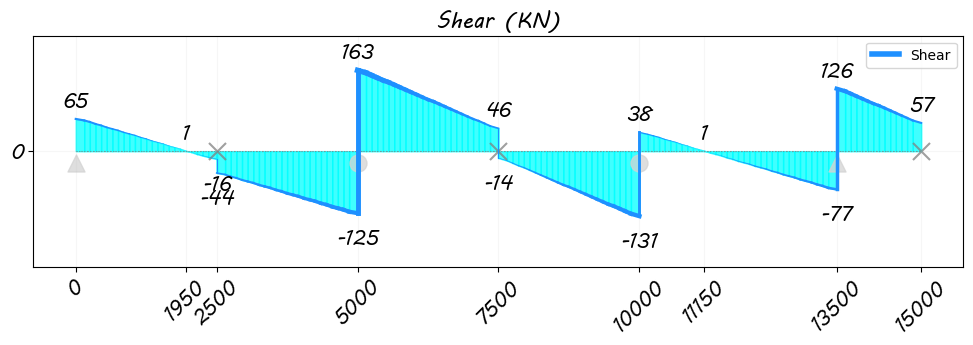

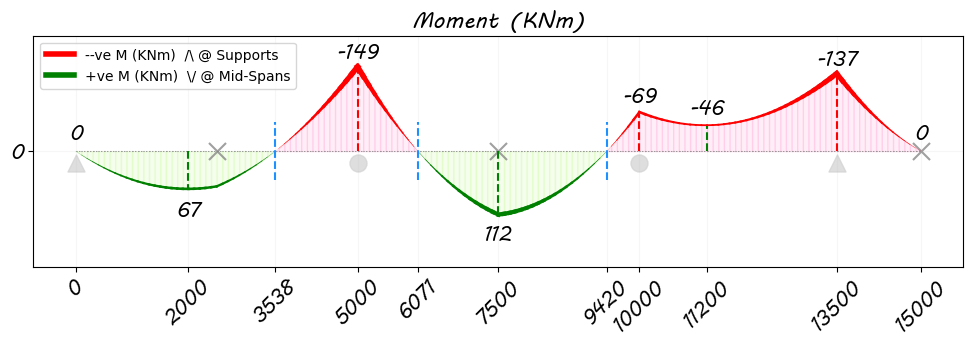

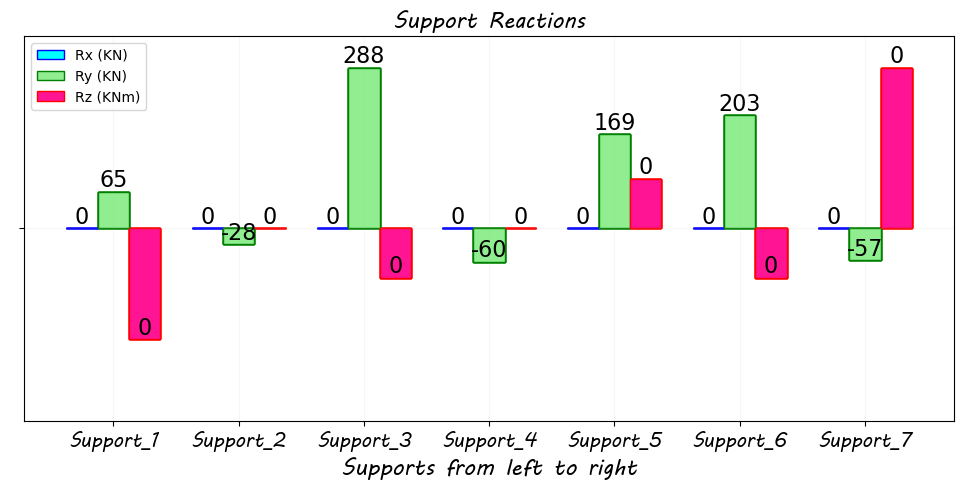

Accuracy  =  98.1 %


In [5]:
# Converting Directions (D.S.M. to Standard.Static) 
# qX  --->  qXs
[ qBs ] = D2S( NB, qB, R )

# finding Global Displacements, Support Reactions & Internal Member Forces
[ Uxyz, Rxyz, AxB,VB,MB ] = xyzNVM( NB, U, R, qBs, nBay )

# Adding Internal Forces to Beams
[ Beams ]  =  Add_member_forces( AxB,VB,MB, Beams )

# finding Max or Min Uy of Main bays
Uy_MxMn = Find_Uy_MxMn( Points, Supports_Idx, Supports, NB, Uxyz )

# plotting deformed-shape
Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, None );   print()
Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, 'V'  );   print()
Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, 'M'  );   print()

# finding 0, Max or Min Shear of Main bays
[ V_Shear, V_MxMn ] = Find_V_MxMn( NB, Beams, Supports_Idx, Supports, wBay_Main, wBay, L_tinyBeam )
# plotting Shear
Plot_Shear( Points, Supports, wBay_Main, wBay, CnB,NB, V_Shear, V_MxMn )

# Finding Flexure Points
Flex = Find_Flexture_Points( Points, NOP, Beams )
# finding  M_MIN @ Supports /\  &  M_MAX @ Mid-Spans \/   of Main bays
[ M_MIN, M_MAX ] = Find_M_MxMn( NOP, NB, Beams )
# plotting Moment
Plot_Moment( Points, Supports, wBay_Main, wBay, CnB,NB,Beams, M_MIN, M_MAX, Flex )

# Visualizing Support Reactions
Plot_Support_Reactions( Rxyz, nPieces )

# Checking Accuracy:   Acc = Sum( Ry ) / Sum( dist. load + Point load )
Accuracy = Find_Accuracy( wBay_Main, W_Beams, Supports, NF, R )
print( 'Accuracy  =  ' + str(Accuracy) + ' %' )

##### 
### Important DataFrames

In [6]:
#Uxyz        # Global Displacements 
#Rxyz        # Support Reactions
#Columns     # Internal Member Forces
#Beams       # Internal Member Forces
#Diagonals   # Internal Member Forces

##### 
### Important Visualizers

In [7]:
#Shape( Points, CnC, CnB, CnD, wBay, hStory )   # Undeformed Shape
#Plot_Deformed( Scale, Undeformed_YN, Points, Uxyz, CnC,CnB,CnD, NC,NB,ND, wBay,hStory )   # Deformed Shape
#Plot_Support_Reactions( Rxyz, nBay )   # Visualizing Support Reactions

##### 

##### 

##### 